# reel driver classifier analysis

## import dependancies

In [8]:
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

## import data

In [9]:
media = pl.read_parquet("../data/media.parquet")
results = pl.read_parquet("../data/binomial_classifier_results.parquet")

display(media.head())
display(results.head())

hash,media_type,media_title,season,episode,release_year,pipeline_status,error_status,error_condition,rejection_status,rejection_reason,parent_path,target_path,original_title,original_path,original_link,rss_source,uploader,genre,language,rt_score,metascore,imdb_rating,imdb_votes,imdb_id,resolution,video_codec,upload_type,audio_codec,created_at,updated_at,tmdb_id
str,cat,str,i64,i64,i64,cat,bool,str,cat,str,str,str,str,str,str,cat,str,list[str],list[str],i64,i64,f64,i64,str,str,str,str,str,datetime[μs],datetime[μs],i64
"""025df4eee2e7cf6862093c6daddbd1…","""movie""","""Barbie & Teresa: Recipe for Fr…",null,null,2025,"""rejected""",false,null,"""rejected""","""rt_score is null""",null,null,"""Barbie and Teresa: Recipe for …",null,"""https://yts.mx/torrent/downloa…","""yts.mx""",null,"[""Animation"", ""Family"", ""Comedy""]","[""en""]",null,null,64.0,44,"""tt33550838""","""1080p""",null,"""WEBRip""",null,2025-05-08 06:06:47.613038,2025-05-08 06:06:47.613038,1425816
"""0182f85b2abd3b2d93104673e2e14d…","""movie""","""Umjolo: Day Ones""",null,null,2024,"""rejected""",false,null,"""rejected""","""language is null""",null,null,"""Umjolo: Day Ones (2024) [1080p…",null,"""https://yts.mx/torrent/downloa…","""yts.mx""",null,"[""Romance"", ""Drama""]","[""zu"", ""en""]",null,null,null,null,"""tt34619564""","""1080p""",null,"""WEBRip""",null,2025-05-08 06:06:47.613038,2025-05-08 06:06:47.613038,1395642
"""01cd6ddc66953460d68ea8caa8c03f…","""movie""","""Imprisoned By Love""",null,null,2013,"""rejected""",false,null,"""rejected""","""rt_score is null""",null,null,"""Imprisoned by Love (2013) [108…",null,"""https://yts.mx/torrent/downloa…","""yts.mx""",null,[],"[""en""]",null,null,56.0,48,"""tt2945250""","""1080p""",null,"""WEBRip""",null,2025-05-08 06:06:47.613038,2025-05-08 06:06:47.613038,323050
"""0270795ba8e7c3f818f00b802391d8…","""movie""","""Prescription: Murder""",null,null,1968,"""rejected""",false,null,"""rejected""","""rt_score is null""",null,null,"""Prescription: Murder (1968) [1…",null,"""https://yts.mx/torrent/downloa…",null,null,"[""Crime"", ""Mystery"", … ""Drama""]","[""en""]",null,null,79.0,5888,"""tt0061496""","""1080p""",null,"""WEBRip""",null,2025-05-08 06:06:47.613038,2025-05-08 06:06:47.613038,509109
"""029bf7b1ec5a6df83851fdf43c775c…","""tv_show""","""South Park""",13,1,1997,"""complete""",false,null,"""accepted""",null,null,null,"""South Park S13E01 The Ring 108…","""South Park S13E01 The Ring 108…","""magnet:?xt=urn:btih:029bf7b1ec…",null,null,"[""Animation"", ""Comedy""]","[""en""]",null,null,87.0,420925,"""tt0121955""","""1080p""","""H 264""","""HMAX""",null,2025-05-08 06:06:47.613038,2025-05-08 06:06:47.613038,2190


actual,predicted,probability,hash
bool,i64,f32,str
false,0,0.00927,"""ef2a28ce50b64a6feeaa18dac3c4f2…"
false,0,0.001725,"""6ba406d44d791ca42ffe5c59bb82b1…"
true,1,0.99139,"""fb1595da4d5b76568fd180f99bdf2f…"
true,1,0.99139,"""e96b86f324da3175d592d27d569141…"
false,0,0.001532,"""a368bff3384d09af06a9e4c9e1bc1d…"


## format data for analysis

In [10]:
# join tables
df = results.join(media, on="hash", how="left")

# coerce predcited to boolean 
df = df.with_columns(pl.col("predicted").cast(pl.Boolean))

# create all confusion matrix fields
df = df.with_columns(
    cm_value = pl.when(pl.col("actual"))
        .then(
            pl.when(pl.col("predicted"))
                .then(pl.lit("TP"))
                .otherwise(pl.lit("FN"))
        ).otherwise(
            pl.when(pl.col("predicted"))
                .then(pl.lit("FP"))
                .otherwise(pl.lit("TN"))        
        )
)

# select only relevant fields
df = df.select(
    "media_title",
    "predicted",
    "actual",
    "cm_value",
    "probability",
    "release_year",
    "rt_score",
    "metascore",
    "imdb_rating",
    "imdb_votes",
    "original_title",
    "hash"
)

display(df.head())

# convert to pandas for compabiltiy 
pdf = df.to_pandas()

media_title,predicted,actual,cm_value,probability,release_year,rt_score,metascore,imdb_rating,imdb_votes,original_title,hash
str,bool,bool,str,f32,i64,i64,i64,f64,i64,str,str
"""The Oath""",false,false,"""TN""",0.00927,2016,75,null,64.0,2490,"""The Oath (2016) [720p] [BluRay…","""ef2a28ce50b64a6feeaa18dac3c4f2…"
"""County Line: No Fear""",false,false,"""TN""",0.001725,2022,null,null,71.0,82,"""County Line: No Fear (2022) [1…","""6ba406d44d791ca42ffe5c59bb82b1…"
"""What Lies Beneath""",true,true,"""TP""",0.99139,2000,47,51,66.0,138928,"""What Lies Beneath (2000) [720p…","""fb1595da4d5b76568fd180f99bdf2f…"
"""Wanderlust""",true,true,"""TP""",0.99139,2012,59,53,56.0,81670,"""Wanderlust (2012) [1080p] [Blu…","""e96b86f324da3175d592d27d569141…"
"""Christmas with Jerks""",false,false,"""TN""",0.001532,2023,null,null,72.0,45,"""Christmas with Jerks (2023) [1…","""a368bff3384d09af06a9e4c9e1bc1d…"


## visualize results

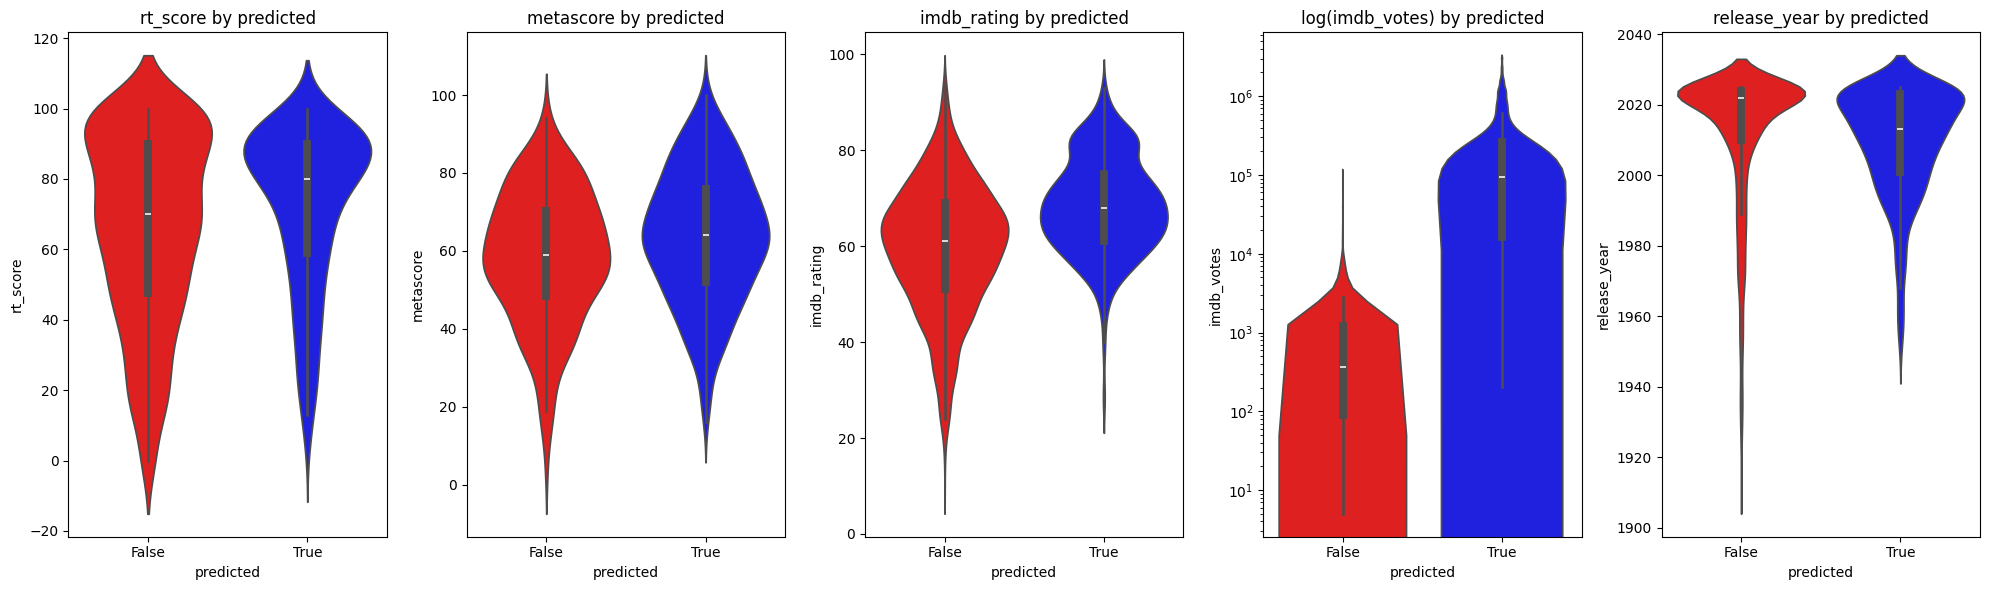

In [11]:
# distribution of numeric values by prediction label

# Create a figure with four subplots side by side
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

# Define the colors for the classes
palette = {False: 'red', True: 'blue'}

# plot
sns.violinplot(x='predicted', y='rt_score', data=pdf, ax=axes[0], hue='predicted', palette=palette)
axes[0].set_title('rt_score by predicted')
axes[0].get_legend().remove()

sns.violinplot(x='predicted', y='metascore', data=pdf, ax=axes[1], hue='predicted', palette=palette)
axes[1].set_title('metascore by predicted')
axes[1].get_legend().remove()

sns.violinplot(x='predicted', y='imdb_rating', data=pdf, ax=axes[2], hue='predicted', palette=palette)
axes[2].set_title('imdb_rating by predicted')
axes[2].get_legend().remove()

sns.violinplot(x='predicted', y='imdb_votes', data=pdf, ax=axes[3], hue='predicted', palette=palette)
axes[3].set_title('log(imdb_votes) by predicted')
axes[3].get_legend().remove()
axes[3].set_yscale('log')

sns.violinplot(x='predicted', y='release_year', data=pdf, ax=axes[4], hue='predicted', palette=palette)
axes[4].set_title('release_year by predicted')
axes[4].get_legend().remove()


# Adjust layout
plt.tight_layout()
plt.show()

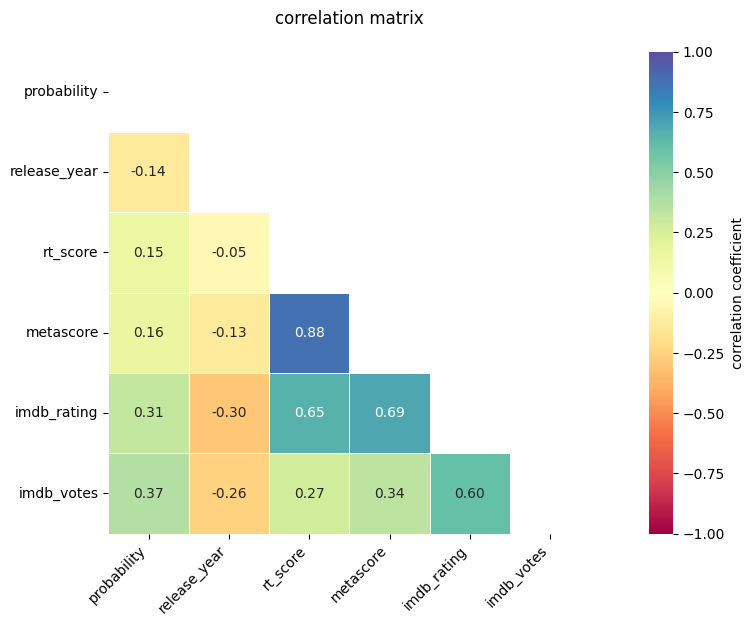

In [12]:
# correlation matrix
corr_df = df.select(
    "probability",
    "release_year",
    "rt_score",
    "metascore",
    "imdb_rating",
    "imdb_votes"
).drop_nulls()

corr_pdf = corr_df.to_pandas()

# Create correlation matrix
corr_matrix = corr_pdf.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,  # Show correlation values
    cmap='Spectral',  # Color scheme
    vmin=-1, vmax=1,  # Value range
    center=0,  # Center the colormap at 0
    square=True,  # Make the plot square-shaped
    fmt='.2f',  # Round correlation values to 2 decimal places
    linewidths=0.5,  # Width of the lines between cells
    cbar_kws={'label': 'correlation coefficient'}
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add title
plt.title('correlation matrix', pad=20)

# Show the plot
plt.show()

In [13]:
# show outliers
# note: the conditional format will not render in github
false_negatives = df.filter(pl.col("cm_value")=="FN").sort("probability").to_pandas()

# Create styled table with conditional formatting
styled_false_negatives = (false_negatives
    .style
    .background_gradient(subset=['probability'], cmap='RdYlGn_r')  # Red to Yellow to Green (reversed)
    .bar(subset=['probability'], color='#4a90e2', align='mid')  # Add bar charts
    .format({'probability': '{:,.0f}', 'probability': '{:.2f}%'})  # Format numbers
    .set_caption('false positives')
)

display(styled_false_negatives)

false_positives = df.filter(pl.col("cm_value")=="FP").sort("probability", descending=True).to_pandas()

# Create styled table with conditional formatting
styled_false_positives = (false_positives
    .style
    .background_gradient(subset=['probability'], cmap='RdYlGn_r')  # Red to Yellow to Green (reversed)
    .bar(subset=['probability'], color='#4a90e2', align='mid')  # Add bar charts
    .format({'probability': '{:,.0f}', 'probability': '{:.2f}%'})  # Format numbers
    .set_caption('false negatives')
)

display(styled_false_positives)

,media_title,predicted,actual,cm_value,probability,release_year,rt_score,metascore,imdb_rating,imdb_votes,original_title,hash
0,Succubus,False,True,FN,0.02%,2024,nan,nan,46.000000,1162,Succubus (2024) [REPACK] [1080p] [WEBRip] [5.1] [YTS.MX],6a368789041c5185ef2b8c7afff540c6797e7dc4
1,Ae Fond Kiss...,False,True,FN,0.02%,2004,88.000000,65.000000,71.000000,7366,A Fond Kiss (2004) [1080p] [WEBRip] [5.1] [YTS.MX],fd8303c7eaa93eeb853649e78695e55a598c1fbe
2,Soundtrack to a Coup d'Etat,False,True,FN,0.02%,2024,97.000000,nan,81.000000,447,Soundtrack to a Coup d'Etat (2024) [1080p] [BluRay] [5.1] [YTS.MX],66258b6d3bf8cb08ca174b05ba6f82a731545531
3,Across the River and Into the Trees,False,True,FN,0.05%,2022,82.000000,nan,67.000000,365,Across the River and Into the Trees (2022) [1080p] [BluRay] [5.1] [YTS.MX],377017e5dff31e591f5cd22329b11ce9696295da
4,Stormy,False,True,FN,0.08%,2024,71.000000,53.000000,64.000000,1064,Stormy (2024) [1080p] [WEBRip] [5.1] [YTS.MX],45b1a04261c58a03bdfeb0e272cb26782dd4db9e
5,Mothers of the Revolution,False,True,FN,0.10%,2021,100.000000,nan,71.000000,47,Mothers Of The Revolution (2021) [1080p] [WEBRip] [5.1] [YTS.MX],b933374c04180215b41b71b19acc1bcb608a11c1
6,Eric Ravilious: Drawn to War,False,True,FN,0.11%,2022,100.000000,nan,nan,56,Eric Ravilious Drawn To War (2022) [1080p] [WEBRip] [YTS.MX],2bdb4c29f6529f982a0dafdadce3227f44088a39
7,Midas Man,False,True,FN,0.13%,2024,82.000000,nan,64.000000,971,Midas Man (2024) [1080p] [BluRay] [5.1] [YTS.MX],73d38f501fe651c53516322e98e42cbb86a7b69e
8,Black Box Diaries,False,True,FN,0.15%,2024,98.000000,82.000000,77.000000,878,Black Box Diaries (2024) [1080p] [WEBRip] [5.1] [YTS.MX],d44c0fadae0c00762e91f93d8e7a322c04159bdb
9,Rumours,False,True,FN,0.16%,2024,75.000000,69.000000,50.000000,4575,Rumours (2024) [1080p] [WEBRip] [x265] [10bit] [5.1] [YTS.MX],e5fa2130f81a3de526a0c427805cbca12e99770f


,media_title,predicted,actual,cm_value,probability,release_year,rt_score,metascore,imdb_rating,imdb_votes,original_title,hash
0,Downhill,True,False,FP,0.93%,2016,83,nan,60.000000,3191,Downhill (2016) [720p] [BluRay] [YTS.MX],d926f83a21d138bf7795a3fe03713e1e63d62fd3
1,To Kill a Tiger,True,False,FP,0.87%,2022,100,nan,76.000000,2545,To Kill a Tiger (2022) [720p] [WEBRip] [YTS.MX],97632cfd0b2ba635ccd3512b5e07f78ea0489429
2,The End We Start From,True,False,FP,0.79%,2023,89,65.000000,59.000000,7877,The End We Start From (2023) [720p] [WEBRip] [YTS.MX],99e2bfe1925c26604fc508f01761643a3563d9d5
3,Accused,True,False,FP,0.79%,2023,100,nan,63.000000,3277,Accused (2023) [1080p] [BluRay] [5.1] [YTS.MX],936e4652df755867ec4ce1e1909ac9cfb91837f6
4,Princess Cyd,True,False,FP,0.73%,2017,95,72.000000,67.000000,4513,Princess Cyd (2017) [720p] [WEBRip] [YTS.MX],d63e25f4ebac199005472b47592e8fa0ed7f2c69
5,The Seventh Fire,True,False,FP,0.72%,2015,92,66.000000,61.000000,205,The Seventh Fire (2015) [1080p] [WEBRip] [5.1] [YTS.MX],abf3f63ff061df89ab8486382e216e9e245a67d0
6,What Still Remains,True,False,FP,0.72%,2018,90,nan,47.000000,2142,What Still Remains (2018) [720p] [WEBRip] [YTS.MX],369086df5b5dbc47bd77402aa36a7754fa6a8f55
7,Y2K,True,False,FP,0.65%,2024,42,49.000000,48.000000,9804,Y2K (2024) [1080p] [BluRay] [5.1] [YTS.MX],09c0b1adaf207e70c379a21759738a86d8f9bd14
8,Things Will Be Different,True,False,FP,0.61%,2024,81,62.000000,52.000000,1443,Things Will Be Different (2024) [1080p] [WEBRip] [x265] [10bit] [5.1] [YTS.MX],162404d7fe479f7a412cc59b7cc72689bd1011db
9,Saloum,True,False,FP,0.58%,2021,96,78.000000,62.000000,3266,Saloum (2021) [720p] [BluRay] [YTS.MX],623003701b666e445aa4f638c73df05aed0aaf4e


In [14]:
# export false positives and false negaties for further investigation
false_positives = df.filter(pl.col('cm_value')=="FP").sort("probability")

with open("../data/false_positives.json", "w") as file:
    # Convert to records (list of dicts, each representing a row)
    records = [row for row in false_positives.iter_rows(named=True)]
    json.dump(records, file, indent=4)

false_negatives = df.filter(pl.col('cm_value')=="FN").sort("probability", descending=True)

with open("../data/false_negatives.json", "w") as file:
    # Convert to records (list of dicts, each representing a row)
    records = [row for row in false_negatives.iter_rows(named=True)]
    json.dump(records, file, indent=4)


### issues discoverd with training data

- parsing issue for some titles leading to issues with metadata collection
    - investigate parsing issues
- some items seems to have properly parsed values for media_title, but still have not succesfully collected metadata
    - re-run through OMDB API
